In [ ]:
# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [ ]:
# Load dataset
#dataset_path = "/dataset_full (1).csv"
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())


Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Preprocessing
data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

In [ ]:
# Train-test split
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# === Neural Field Attention Layer Definition ===
class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=10, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Learnable interaction kernel for evolving attention field
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super(NeuralFieldAttention, self).build(input_shape)

    def call(self, inputs):
        I = inputs  # Initial input feature map [batch_size, seq_len, feature_dim]
        u = tf.zeros_like(I)  # Initial attention field

        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)  # Inter-feature interaction
            activation = tf.nn.relu(u)  # Apply non-linearity (optional)

            # Compute a difficulty signal based on token-wise deviation from the mean
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])

            # Update attention field
            u = u + (-u + interaction + I + self.lambda_strength * delta)

        # Softmax across sequence dimension to get attention weights
        attention_scores = tf.nn.softmax(u, axis=1)

        # Weighted sum to get attended feature representation
        attended_output = tf.reduce_sum(attention_scores * inputs, axis=1)

        return attended_output

    def get_config(self):
        config = super(NeuralFieldAttention, self).get_config()
        config.update({
            'timesteps': self.timesteps,
            'lambda_strength': self.lambda_strength
        })
        return config


In [ ]:
# === Build CNN Model with Neural Field Attention ===
from tensorflow.keras.layers import Reshape

model = Sequential()
# First convolutional block
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Second convolutional block
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten the output for dense layers
model.add(Flatten())

# Neural Field Attention layer instead of flattening
timesteps = 8
features_per_step = 1664 // timesteps  # 208

model.add(Reshape((timesteps, features_per_step)))
model.add(NeuralFieldAttention(timesteps=5, lambda_strength=0.2))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model with standard binary classification metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Track epoch timing
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 109, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 52, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 26, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1664)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 208)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention               │ (None, 208)                 │          43,264 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          26,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,673 (330.75 KB)

 Trainable params: 84,673 (330.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=32,
                    callbacks=[early_stopping, time_callback],
                    verbose=1)

Epoch 1/50
2179/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.9266 - Precision: 0.7556 - Recall: 0.9146 - accuracy: 0.8682 - loss: 0.3120Epoch 1 Time: 92.75s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 93s 40ms/step - AUC: 0.9267 - Precision: 0.7557 - Recall: 0.9146 - accuracy: 0.8682 - loss: 0.3119 - val_AUC: 0.9716 - val_Precision: 0.8315 - val_Recall: 0.9249 - val_accuracy: 0.9082 - val_loss: 0.2073
Epoch 2/50
2179/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.9655 - Precision: 0.8343 - Recall: 0.9081 - accuracy: 0.9051 - loss: 0.2215Epoch 2 Time: 134.72s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 135s 37ms/step - AUC: 0.9655 - Precision: 0.8343 - Recall: 0.9081 - accuracy: 0.9051 - loss: 0.2215 - val_AUC: 0.9764 - val_Precision: 0.8769 - val_Recall: 0.8821 - val_accuracy: 0.9155 - val_loss: 0.1882
Epoch 3/50
2179/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9714 - Precision: 0.8524 - Recall: 0.9044 - accuracy: 0.9111 - loss: 0.2041Epoch 3 Time: 79.86s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - A

In [ ]:
# Evaluate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


In [ ]:
# Print metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Metrics:
Accuracy: 0.9550
Precision: 0.9417
Recall: 0.9288
AUC: 0.9489
Confusion Matrix:
[[10992   351]
 [  434  5665]]


In [ ]:
# FAR & FRR calculations
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


FAR: 0.0309
FRR: 0.0712


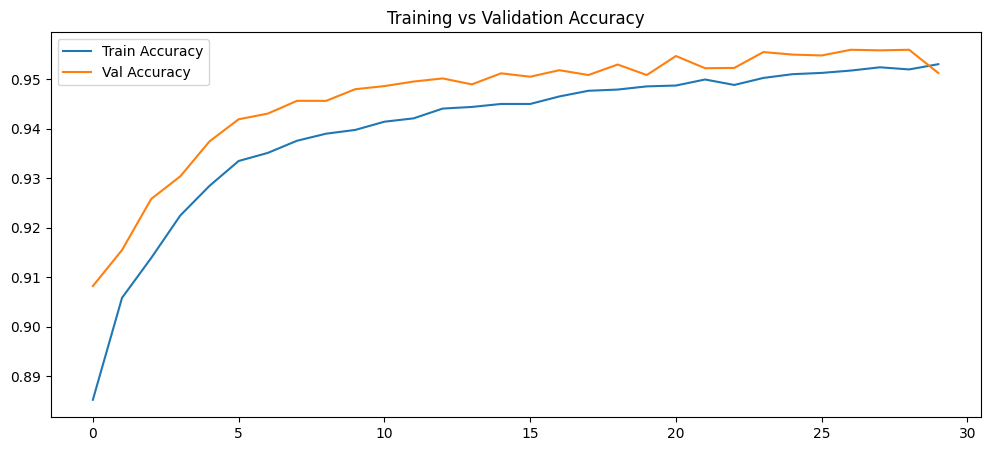

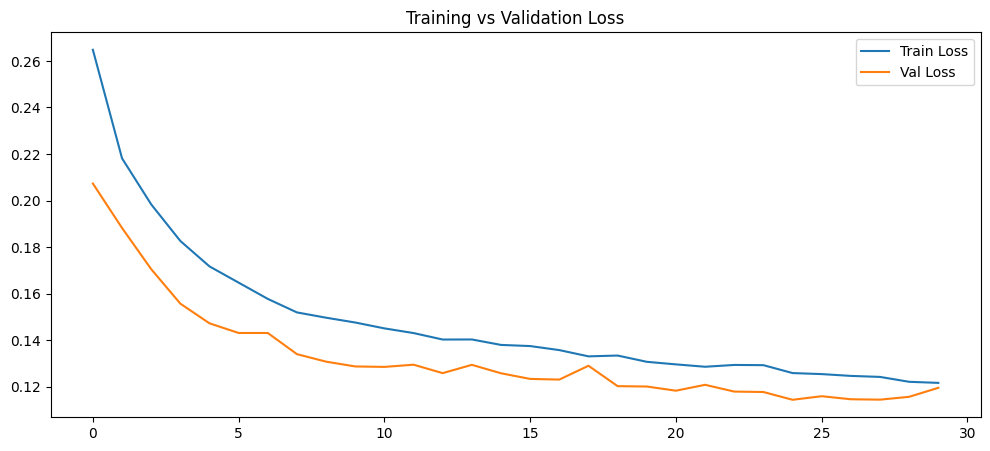

In [ ]:
# Save model history and visualize training curves
np.save("model_history_cnn_nfa.npy", history.history)
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()